# Import the required libraries

In [ ]:
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA,ARMA
#from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm

1) ! pip install -q kaggle

2) from google.colab import files

files.upload()

3) ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

4) ! chmod 600 ~/.kaggle/kaggle.json
5) ! kaggle datasets list
! kaggle datasets list
! kaggle competitions download -c 'name-of-competition'
! unzip train.zip -d train

In [ ]:
! pip install -q kaggle

In [ ]:
#! cp /content/drive/MyDrive/kaggle.json

In [ ]:
#cp --help

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sundarsingh","key":"73c2ab0b0bd0d27cddaaca1995eb7499"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download jpx-tokyo-stock-exchange-prediction

 98% 233M/237M [00:01<00:00, 222MB/s]
100% 237M/237M [00:01<00:00, 201MB/s]


In [ ]:
! unzip jpx-tokyo-stock-exchange-prediction.zip #-d train

Archive:  jpx-tokyo-stock-exchange-prediction.zip
  inflating: data_specifications/options_spec.csv  
  inflating: data_specifications/stock_fin_spec.csv  
  inflating: data_specifications/stock_list_spec.csv  
  inflating: data_specifications/stock_price_spec.csv  
  inflating: data_specifications/trades_spec.csv  
  inflating: example_test_files/financials.csv  
  inflating: example_test_files/options.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/secondary_stock_prices.csv  
  inflating: example_test_files/stock_prices.csv  
  inflating: example_test_files/trades.csv  
  inflating: jpx_tokyo_market_prediction/__init__.py  
  inflating: jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: stock_list.csv          
  inflating: supplemental_files/financials.csv  
  inflating: supplemental_files/options.csv  
  inflating: supplemental_files/secondary_stock_prices.csv  
  inflating: supplemental_files/stock_

# To know the what to predict we look the sample submission

In [ ]:
sample = pd.read_csv("/content/example_test_files/sample_submission.csv")

In [ ]:
sample

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4
...,...,...,...
111995,2022-02-28,9990,1995
111996,2022-02-28,9991,1996
111997,2022-02-28,9993,1997
111998,2022-02-28,9994,1998


In [ ]:
sample.nunique()

Date                56
SecuritiesCode    2000
Rank              2000
dtype: int64

#Competition Metrics

JPX Competition Metric
In this competition, the following conditions set will be used to compete for scores.

The model will use the closing price ( 𝐶(𝑘,𝑡) ) until that business day ( 𝑡 ) and other data every business day as input data for a stock ( 𝑘 ), and predict rate of change ( 𝑟(𝑘,𝑡) ) of closing price of the top 200 stocks and bottom 200 stocks on the following business day ( 𝐶(𝑘,𝑡+1) ) to next following business day ( 𝐶(𝑘,𝑡+2) )

𝑟(𝑘,𝑡)=𝐶(𝑘,𝑡+2)−𝐶(𝑘,𝑡+1)𝐶(𝑘,𝑡+1)
 
Within top 200 stock predicted ( 𝑢𝑝𝑖(𝑖=1,2,…,200) ), multiply by their respective rate of change with linear weights of 2-1 for rank 1-200 and denote their sum as  𝑆𝑢𝑝 .

𝑆𝑢𝑝=∑200𝑖=1(𝑟(𝑢𝑝𝑖,𝑡)∗𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1)𝑖))𝐴𝑣𝑒𝑟𝑎𝑔𝑒(𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1))
 
Within bottom 200 stocks predicted ( 𝑑𝑜𝑤𝑛𝑖(𝑖=1,2,…,200) ), multiply by their respective rate of change with linear weights of 2-1 for bottom rank 1-200 and denote their sum as  𝑆𝑑𝑜𝑤𝑛 .

𝑆𝑑𝑜𝑤𝑛=∑200𝑖=1(𝑟(𝑑𝑜𝑤𝑛𝑖,𝑡)∗𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1)𝑖)𝐴𝑣𝑒𝑟𝑎𝑔𝑒(𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1))
 
The result of subtracting  𝑆𝑑𝑜𝑤𝑛  from  𝑆𝑢𝑝  is  𝑅𝑑𝑎𝑦  and is called "daily spread return".

𝑅𝑑𝑎𝑦=𝑆𝑢𝑝−𝑆𝑑𝑜𝑤𝑛
 
The daily spread return is calculated every business day during the public/private period and obtained as a time series for that period. The mean/standard deviation of the time series of daily spread returns is used as the score. Score calculation formula (x is the business day of public/private period)

𝑆𝑐𝑜𝑟𝑒=𝐴𝑣𝑒𝑟𝑎𝑔𝑒(𝑅𝑑𝑎𝑦1−𝑑𝑎𝑦𝑥)𝑆𝑇𝐷(𝑅𝑑𝑎𝑦1−𝑑𝑎𝑦𝑥)
 
The Kagger with the largest score for the private period wins.

In [ ]:
stock_prices_train = pd.read_csv("/content/train_files/stock_prices.csv",parse_dates=['Date'],index_col=['Date'])

In [ ]:
stock_prices_train

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,20211203_9990,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2021-12-03,20211203_9991,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2021-12-03,20211203_9993,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302


In [ ]:
stock_prices_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   SecuritiesCode    int64  
 2   Open              float64
 3   High              float64
 4   Low               float64
 5   Close             float64
 6   Volume            int64  
 7   AdjustmentFactor  float64
 8   ExpectedDividend  float64
 9   SupervisionFlag   bool   
 10  Target            float64
dtypes: bool(1), float64(7), int64(2), object(1)
memory usage: 198.0+ MB


In [ ]:
stock_prices_train.isnull().sum()

RowId                     0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

In [ ]:
stock_prices_train1 = stock_prices_train.dropna()

In [ ]:
stock_prices_train1.isnull().sum()

RowId               0
SecuritiesCode      0
Open                0
High                0
Low                 0
Close               0
Volume              0
AdjustmentFactor    0
ExpectedDividend    0
SupervisionFlag     0
Target              0
dtype: int64

In [ ]:
stock_prices_train1 = stock_prices_train1.drop(columns=['RowId','SupervisionFlag'])

In [ ]:
stock_prices_train1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18841 entries, 2017-01-16 to 2021-11-25
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SecuritiesCode    18841 non-null  int64  
 1   Open              18841 non-null  float64
 2   High              18841 non-null  float64
 3   Low               18841 non-null  float64
 4   Close             18841 non-null  float64
 5   Volume            18841 non-null  int64  
 6   AdjustmentFactor  18841 non-null  float64
 7   ExpectedDividend  18841 non-null  float64
 8   Target            18841 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.4 MB


In [ ]:
stock_prices_train1.describe()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,1.884100e+04,18841.0,18841.000000,18841.000000
mean,5933.073775,2626.378557,2659.169439,2592.136712,2628.699225,7.700559e+05,1.0,22.014382,-0.010002
std,2390.600296,3663.336905,3706.333390,3623.337749,3669.192860,4.384669e+06,0.0,29.871713,0.025209
min,1301.000000,20.000000,21.000000,19.000000,20.000000,1.000000e+02,1.0,0.000000,-0.578541
25%,3922.000000,1018.000000,1032.000000,1003.000000,1018.000000,4.300000e+04,1.0,5.000000,-0.022926
50%,6266.000000,1813.000000,1839.000000,1790.000000,1815.000000,1.306000e+05,1.0,15.000000,-0.009909
75%,7979.000000,3040.000000,3080.000000,2999.000000,3045.000000,4.460000e+05,1.0,30.000000,0.002494
max,9997.000000,105750.000000,107100.000000,104400.000000,104900.000000,2.377070e+08,1.0,1070.000000,0.282486


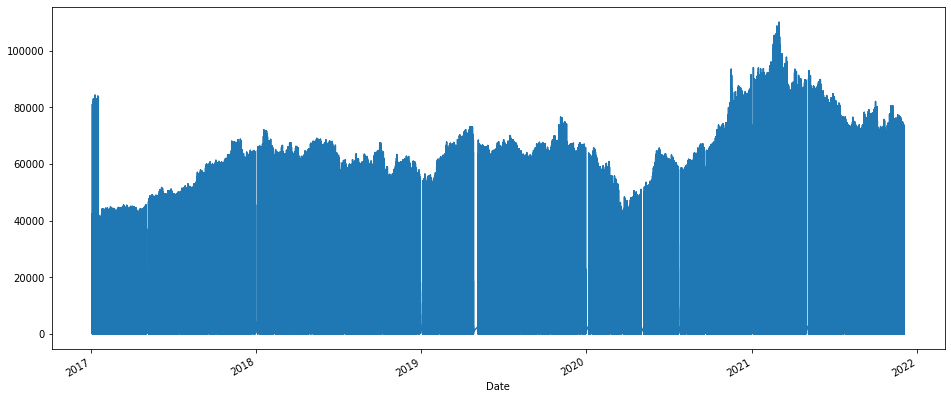

In [ ]:
stock_prices_train['Open'].plot(figsize=(16,7))

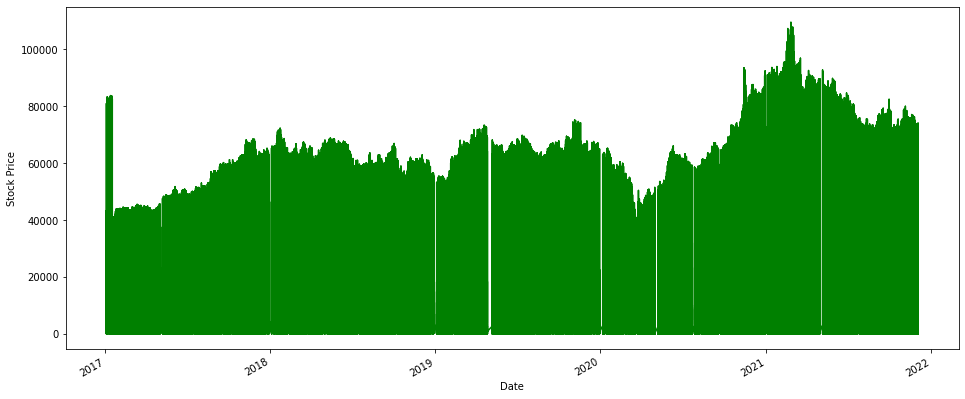

In [ ]:
stock_prices_train['Close'].plot(figsize=(16,7),c='g',ylabel="Stock Price")

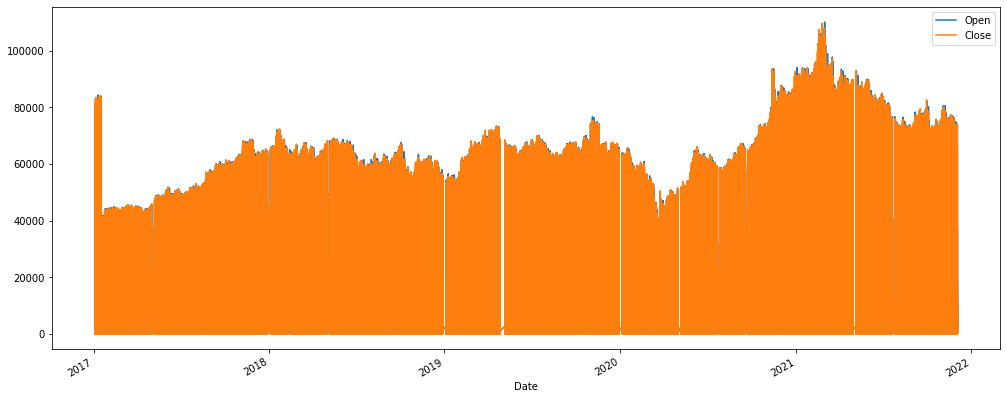

In [ ]:
stock_prices_train.plot.line(y=['Open','Close'], figsize=(17,7))

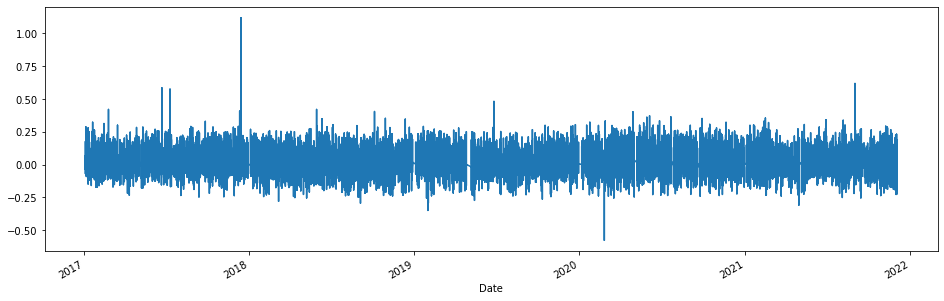

In [ ]:
stock_prices_train['Target'].plot(figsize=(16,5))

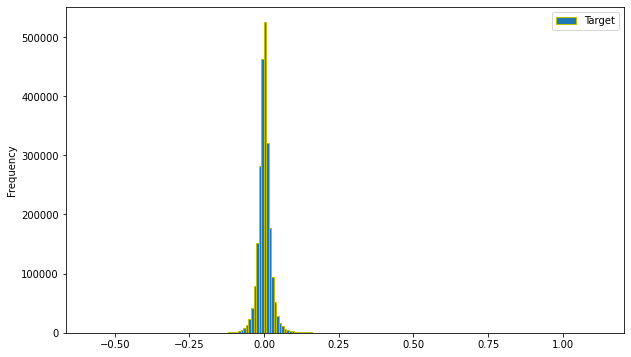

In [ ]:
stock_prices_train.plot.hist(y='Target', figsize=(10,6),bins=200,edgecolor='y')

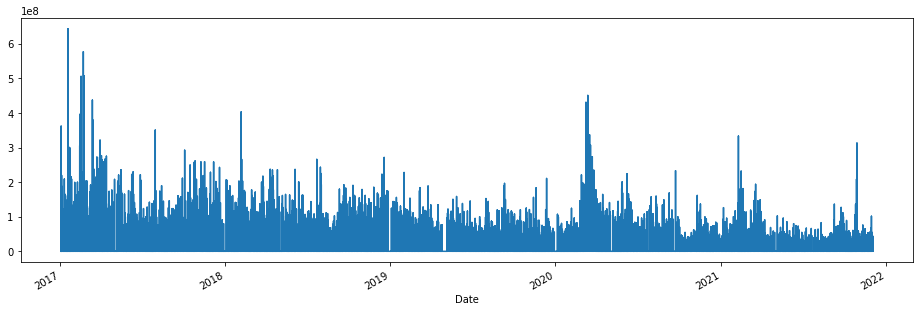

In [ ]:
stock_prices_train['Volume'].plot(figsize=(16,5))

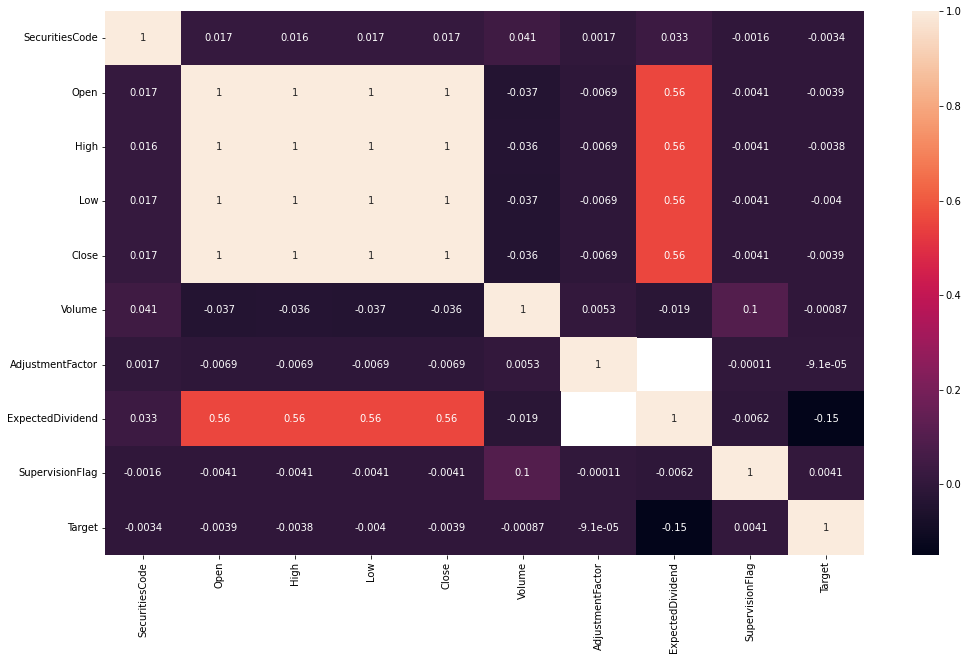

In [ ]:
plt.figure(figsize=(17,10))
sns.heatmap(stock_prices_train.corr(), annot=True)

# Manual calclations of Target/rate of chage by the help of given metrics

# Let us try to calculate the Target(ie. rate of change) as per given formulae in metrics

# 𝑟(𝑘,𝑡)=(𝐶(𝑘,𝑡+2)−𝐶(𝑘,𝑡+1))/𝐶(𝑘,𝑡+1)

# r = Rate of change
# k = stock
# t = time

In [ ]:
# let's take one stock
stock = stock_prices_train[stock_prices_train["SecuritiesCode"]==7777].reset_index(drop=True)
stock.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_7777,7777,647.0,693.0,647.0,690.0,257300,1.0,NaN,False,-0.018336
1,20170105_7777,7777,700.0,716.0,700.0,709.0,301000,1.0,NaN,False,0.143678
2,20170106_7777,7777,712.0,725.0,692.0,696.0,198100,1.0,NaN,False,-0.027638
3,20170110_7777,7777,739.0,796.0,732.0,796.0,1069800,1.0,NaN,False,-0.032300
4,20170111_7777,7777,812.0,815.0,758.0,774.0,630600,1.0,NaN,False,0.012016


In [ ]:
# Applying formulae

stock["rate_of_change"] = (stock["Close"].shift(-2) - stock["Close"].shift(-1)) / stock["Close"].shift(-1)
stock.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rate_of_change
0,20170104_7777,7777,647.0,693.0,647.0,690.0,257300,1.0,NaN,False,-0.018336,-0.018336
1,20170105_7777,7777,700.0,716.0,700.0,709.0,301000,1.0,NaN,False,0.143678,0.143678
2,20170106_7777,7777,712.0,725.0,692.0,696.0,198100,1.0,NaN,False,-0.027638,-0.027638
3,20170110_7777,7777,739.0,796.0,732.0,796.0,1069800,1.0,NaN,False,-0.032300,-0.032300
4,20170111_7777,7777,812.0,815.0,758.0,774.0,630600,1.0,NaN,False,0.012016,0.012016


# In above we can observe that given 'Target' and calcuated 'rate of change' are same. Hence our calculation is correct

In [ ]:
# Now we need to give the rank as per rate of change by descending order
# The rank should be calculated in given stocks 
# let take any date radomly
rank = stock_prices_train[stock_prices_train.index=="2021-12-03"].reset_index(drop=True)
rank.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211203_1301,1301,2983.0,2983.0,2965.0,2982.0,11400,1.0,NaN,False,0.031639
1,20211203_1332,1332,579.0,585.0,570.0,585.0,1195500,1.0,NaN,False,-0.056027
2,20211203_1333,1333,2333.0,2358.0,2315.0,2358.0,103200,1.0,NaN,False,0.013462
3,20211203_1375,1375,1222.0,1236.0,1218.0,1235.0,69900,1.0,NaN,False,0.032680
4,20211203_1376,1376,1370.0,1370.0,1321.0,1332.0,5000,1.0,NaN,False,0.032568


In [ ]:
rank["rank"] = rank["Target"].rank(ascending=False,method="first") -1 
rank = rank.sort_values("rank").reset_index(drop=True)

In [ ]:
rank

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank
0,20211203_4699,4699,2140.0,2180.0,2117.0,2160.0,19700,1.0,NaN,True,0.187970,0.0
1,20211203_1873,1873,342.0,352.0,340.0,352.0,84200,1.0,NaN,False,0.186782,1.0
2,20211203_6779,6779,1558.0,1582.0,1489.0,1546.0,519200,1.0,NaN,False,0.159624,2.0
3,20211203_7809,7809,6060.0,6430.0,5830.0,6410.0,46300,1.0,NaN,False,0.136667,3.0
4,20211203_3031,3031,1191.0,1193.0,1155.0,1155.0,1651500,1.0,NaN,False,0.119069,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20211203_6958,6958,527.0,528.0,503.0,514.0,436000,1.0,NaN,False,-0.058201,1995.0
1996,20211203_9790,9790,3825.0,3890.0,3820.0,3860.0,23200,1.0,NaN,False,-0.084321,1996.0
1997,20211203_2158,2158,3105.0,3245.0,2365.0,2365.0,11828500,1.0,NaN,False,-0.091797,1997.0
1998,20211203_6718,6718,2156.0,2212.0,2133.0,2194.0,49600,1.0,NaN,False,-0.092211,1998.0


# calculating the "Daily spread return" Using Sum up and sum down


# 𝑅𝑑𝑎𝑦 = 𝑆𝑢𝑝−𝑆𝑑𝑜𝑤𝑛

# Within top 200 stock predicted ( 𝑢𝑝𝑖(𝑖=1,2,…,200) ), multiply by their respective rate of change with linear weights of 2-1 for rank 1-200 and denote their sum as  𝑆𝑢𝑝 .

# 𝑆𝑢𝑝 = ∑200𝑖=1(𝑟(𝑢𝑝𝑖,𝑡)∗𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1)𝑖))/𝐴𝑣𝑒𝑟𝑎𝑔𝑒(𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1))

# Within bottom 200 stocks predicted ( 𝑑𝑜𝑤𝑛𝑖(𝑖=1,2,…,200) ), multiply by their respective rate of change with linear weights of 2-1 for bottom rank 1-200 and denote their sum as  𝑆𝑑𝑜𝑤𝑛 .

# 𝑆𝑑𝑜𝑤𝑛=∑200𝑖=1(𝑟(𝑑𝑜𝑤𝑛𝑖,𝑡)∗𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1)𝑖)𝐴𝑣𝑒𝑟𝑎𝑔𝑒(𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1))
 


In [ ]:
# Now we need to calculte the "Daily Spread Retun" By using given formulae
#Rday = Sup - Sdown 

# Sup = ∑200𝑖=1(𝑟(𝑢𝑝𝑖,𝑡)∗𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1)𝑖))/𝐴𝑣𝑒𝑟𝑎𝑔𝑒(𝑙𝑖𝑛𝑒𝑎𝑟𝑓𝑢𝑛𝑐𝑡𝑖𝑜𝑛(2,1))

In [ ]:
Top_200Stocks = rank.iloc[:200,:]
Top_200Stocks

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank
0,20211203_4699,4699,2140.0,2180.0,2117.0,2160.0,19700,1.0,NaN,True,0.187970,0.0
1,20211203_1873,1873,342.0,352.0,340.0,352.0,84200,1.0,NaN,False,0.186782,1.0
2,20211203_6779,6779,1558.0,1582.0,1489.0,1546.0,519200,1.0,NaN,False,0.159624,2.0
3,20211203_7809,7809,6060.0,6430.0,5830.0,6410.0,46300,1.0,NaN,False,0.136667,3.0
4,20211203_3031,3031,1191.0,1193.0,1155.0,1155.0,1651500,1.0,NaN,False,0.119069,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,20211203_7570,7570,1950.0,1983.0,1920.0,1973.0,20500,1.0,NaN,False,0.047980,195.0
196,20211203_7354,7354,3730.0,3845.0,3690.0,3845.0,75100,1.0,NaN,False,0.047936,196.0
197,20211203_8570,8570,1198.0,1235.0,1187.0,1235.0,827900,1.0,NaN,False,0.047890,197.0
198,20211203_9628,9628,1428.0,1465.0,1398.0,1459.0,23000,1.0,NaN,False,0.047814,198.0


In [ ]:
weights = np.linspace(start=2, stop=1, num=200)
weights

array([2.        , 1.99497487, 1.98994975, 1.98492462, 1.9798995 ,
       1.97487437, 1.96984925, 1.96482412, 1.95979899, 1.95477387,
       1.94974874, 1.94472362, 1.93969849, 1.93467337, 1.92964824,
       1.92462312, 1.91959799, 1.91457286, 1.90954774, 1.90452261,
       1.89949749, 1.89447236, 1.88944724, 1.88442211, 1.87939698,
       1.87437186, 1.86934673, 1.86432161, 1.85929648, 1.85427136,
       1.84924623, 1.84422111, 1.83919598, 1.83417085, 1.82914573,
       1.8241206 , 1.81909548, 1.81407035, 1.80904523, 1.8040201 ,
       1.79899497, 1.79396985, 1.78894472, 1.7839196 , 1.77889447,
       1.77386935, 1.76884422, 1.7638191 , 1.75879397, 1.75376884,
       1.74874372, 1.74371859, 1.73869347, 1.73366834, 1.72864322,
       1.72361809, 1.71859296, 1.71356784, 1.70854271, 1.70351759,
       1.69849246, 1.69346734, 1.68844221, 1.68341709, 1.67839196,
       1.67336683, 1.66834171, 1.66331658, 1.65829146, 1.65326633,
       1.64824121, 1.64321608, 1.63819095, 1.63316583, 1.62814

In [ ]:
Top_200Stocks["weights"] = weights
Top_200Stocks.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights
0,20211203_4699,4699,2140.0,2180.0,2117.0,2160.0,19700,1.0,NaN,True,0.187970,0.0,2.000000
1,20211203_1873,1873,342.0,352.0,340.0,352.0,84200,1.0,NaN,False,0.186782,1.0,1.994975
2,20211203_6779,6779,1558.0,1582.0,1489.0,1546.0,519200,1.0,NaN,False,0.159624,2.0,1.989950
3,20211203_7809,7809,6060.0,6430.0,5830.0,6410.0,46300,1.0,NaN,False,0.136667,3.0,1.984925
4,20211203_3031,3031,1191.0,1193.0,1155.0,1155.0,1651500,1.0,NaN,False,0.119069,4.0,1.979899


In [ ]:
Top_200Stocks["calculated_weights"] = Top_200Stocks["Target"] * Top_200Stocks["weights"]
Top_200Stocks.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights,calculated_weights
0,20211203_4699,4699,2140.0,2180.0,2117.0,2160.0,19700,1.0,NaN,True,0.187970,0.0,2.000000,0.375940
1,20211203_1873,1873,342.0,352.0,340.0,352.0,84200,1.0,NaN,False,0.186782,1.0,1.994975,0.372625
2,20211203_6779,6779,1558.0,1582.0,1489.0,1546.0,519200,1.0,NaN,False,0.159624,2.0,1.989950,0.317645
3,20211203_7809,7809,6060.0,6430.0,5830.0,6410.0,46300,1.0,NaN,False,0.136667,3.0,1.984925,0.271273
4,20211203_3031,3031,1191.0,1193.0,1155.0,1155.0,1651500,1.0,NaN,False,0.119069,4.0,1.979899,0.235745


In [ ]:
Sup = Top_200Stocks["calculated_weights"].sum()/np.mean(weights)
Sup

12.784119119374031

In [ ]:
Bottom_200Stocks = rank.iloc[-200:,:]
Bottom_200Stocks = Bottom_200Stocks.sort_values("rank",ascending = False).reset_index(drop=True)
Bottom_200Stocks

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank
0,20211203_9919,9919,1817.0,1845.0,1802.0,1829.0,55200,1.0,NaN,False,-0.224215,1999.0
1,20211203_6718,6718,2156.0,2212.0,2133.0,2194.0,49600,1.0,NaN,False,-0.092211,1998.0
2,20211203_2158,2158,3105.0,3245.0,2365.0,2365.0,11828500,1.0,NaN,False,-0.091797,1997.0
3,20211203_9790,9790,3825.0,3890.0,3820.0,3860.0,23200,1.0,NaN,False,-0.084321,1996.0
4,20211203_6958,6958,527.0,528.0,503.0,514.0,436000,1.0,NaN,False,-0.058201,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,20211203_9757,9757,2626.0,2663.0,2622.0,2641.0,75000,1.0,NaN,False,0.006865,1804.0
196,20211203_7278,7278,1642.0,1666.0,1640.0,1662.0,98600,1.0,NaN,False,0.007084,1803.0
197,20211203_6723,6723,1395.0,1400.0,1340.0,1397.0,11109600,1.0,NaN,False,0.007133,1802.0
198,20211203_2871,2871,2643.0,2664.0,2620.0,2664.0,382300,1.0,NaN,False,0.007154,1801.0


In [ ]:
Bottom_200Stocks["weights"] = weights
Bottom_200Stocks.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights
0,20211203_9919,9919,1817.0,1845.0,1802.0,1829.0,55200,1.0,NaN,False,-0.224215,1999.0,2.000000
1,20211203_6718,6718,2156.0,2212.0,2133.0,2194.0,49600,1.0,NaN,False,-0.092211,1998.0,1.994975
2,20211203_2158,2158,3105.0,3245.0,2365.0,2365.0,11828500,1.0,NaN,False,-0.091797,1997.0,1.989950
3,20211203_9790,9790,3825.0,3890.0,3820.0,3860.0,23200,1.0,NaN,False,-0.084321,1996.0,1.984925
4,20211203_6958,6958,527.0,528.0,503.0,514.0,436000,1.0,NaN,False,-0.058201,1995.0,1.979899


In [ ]:
Bottom_200Stocks["calculated_weights"] = Bottom_200Stocks["Target"] * Bottom_200Stocks["weights"]
Bottom_200Stocks.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights,calculated_weights
0,20211203_9919,9919,1817.0,1845.0,1802.0,1829.0,55200,1.0,NaN,False,-0.224215,1999.0,2.000000,-0.448430
1,20211203_6718,6718,2156.0,2212.0,2133.0,2194.0,49600,1.0,NaN,False,-0.092211,1998.0,1.994975,-0.183959
2,20211203_2158,2158,3105.0,3245.0,2365.0,2365.0,11828500,1.0,NaN,False,-0.091797,1997.0,1.989950,-0.182671
3,20211203_9790,9790,3825.0,3890.0,3820.0,3860.0,23200,1.0,NaN,False,-0.084321,1996.0,1.984925,-0.167372
4,20211203_6958,6958,527.0,528.0,503.0,514.0,436000,1.0,NaN,False,-0.058201,1995.0,1.979899,-0.115232


In [ ]:
Sdown = Bottom_200Stocks["calculated_weights"].sum()/np.mean(weights)
Sdown

-1.6545226418872847

In [ ]:
#daily_spread_return 
Rday = Sup - Sdown
Rday

14.438641761261316

In [ ]:
# Now By appling Time siries  model we can predict lower and upper prices

In [ ]:
x = stock_prices_train1[['SecuritiesCode','Close']]
y = stock_prices_train1['Target']
print(x)
print(y)

            SecuritiesCode   Close
Date                              
2017-01-16            2590  6060.0
2017-01-16            4699  1087.0
2017-01-25            1928  1871.5
2017-01-25            2217   512.0
2017-01-25            2353   152.0
...                    ...     ...
2021-11-25            8923  1030.0
2021-11-25            9278   990.0
2021-11-25            9369  1990.0
2021-11-25            9717  1223.0
2021-11-25            9837   672.0

[18841 rows x 2 columns]
Date
2017-01-16    0.005051
2017-01-16   -0.032833
2017-01-25   -0.018336
2017-01-25    0.016000
2017-01-25   -0.006452
                ...   
2021-11-25   -0.073099
2021-11-25    0.000000
2021-11-25   -0.057692
2021-11-25   -0.127517
2021-11-25   -0.043675
Name: Target, Length: 18841, dtype: float64


In [ ]:
x.isnull().sum()

SecuritiesCode    0
Close             0
dtype: int64

In [ ]:
y.isnull().sum()

0

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols 

In [ ]:
from pylab import rcParams
rcParams['figure.figsize']=12,3

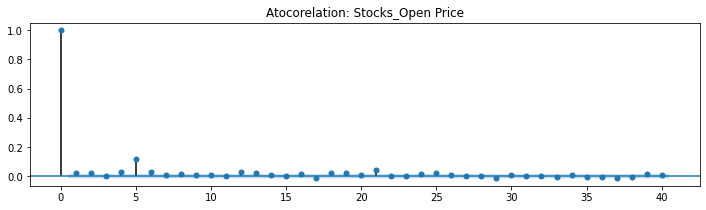

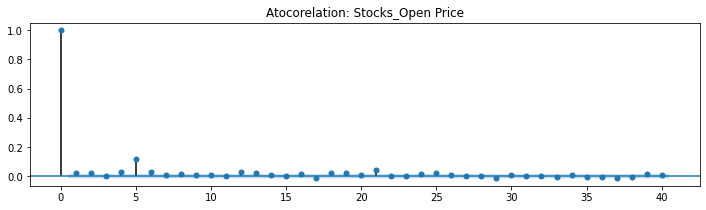

In [ ]:
sm.graphics.tsa.plot_acf(x['Close'],title='Atocorelation: Stocks_Open Price',lags=40)

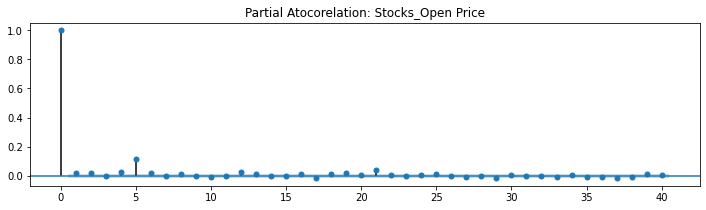

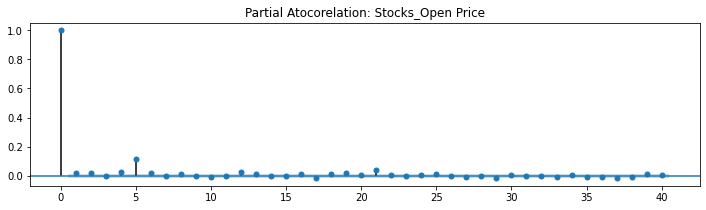

In [ ]:
sm.graphics.tsa.plot_pacf(x['Close'],title='Partial Atocorelation: Stocks_Open Price',lags=40)

In [ ]:
from fbprophet import Prophet

In [ ]:
def train_ph_model(df):
    m = Prophet()
    ph_df = df[['Close','Date']].copy()
    ph_df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
    m.fit(ph_df)
    return m

In [ ]:
m = train_ph_model(x["Close"].reset_index().copy())
future_prices = m.make_future_dataframe(periods=56)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(56)

,ds,yhat,yhat_lower,yhat_upper
131,2021-11-26,3282.156624,-1400.936763,8103.468130
132,2021-11-27,5137.042033,562.554240,10069.054554
133,2021-11-28,4924.991545,-70.458081,9331.191693
134,2021-11-29,2806.727991,-1889.273615,7415.001914
135,2021-11-30,2682.768747,-2127.389342,7527.893176
136,2021-12-01,2443.253253,-2066.635816,7033.022548
137,2021-12-02,2282.891295,-2569.234280,6767.473741
138,2021-12-03,2000.781793,-2624.642174,6848.993487
139,2021-12-04,3967.808060,-485.790589,8872.429730
140,2021-12-05,3891.978951,-581.572303,8610.523766


          ds         yhat   yhat_lower    yhat_upper
0 2017-01-16     8.620786 -4695.132342   4589.044916
1 2017-01-25  2348.093078 -2069.672731   7077.741255
2 2017-02-14  3362.537017 -1487.581634   7988.869994
3 2017-02-22  3149.810942 -1536.833422   7592.912951
4 2017-03-09  7039.666129  2140.712148  12004.907337


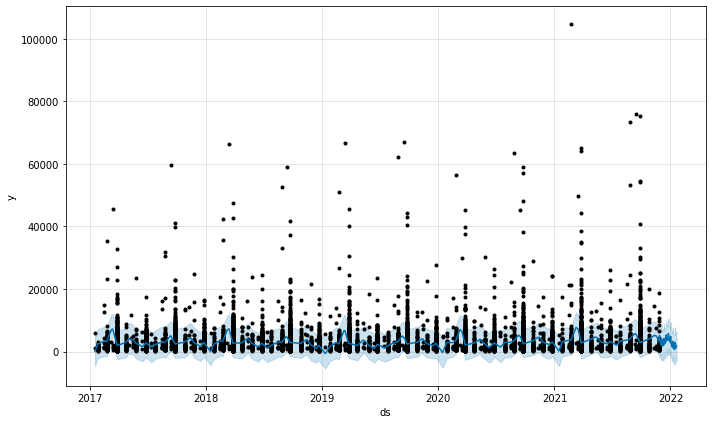

In [ ]:
# plot forecast 
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
m.plot(forecast);

# 2nd model I am appling Nural networks to predict the ranks

# Its a very challenging for me wehen I am appling classroom learn models even in time series method also I faced very challinging. Time series model doing with nural network its very new to me. After observing different models I got below model.Still I am not satisfied with this. Due to time is not sfficent I am uploading up to this. After this I am planning to do xgboost and LSTM methods as well. I need time to do this 

In [ ]:
import jpx_tokyo_market_prediction
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
train_data = stock_prices_train1[stock_prices_train1.index < '2021-01-01'].copy()
train_data.shape

(15221, 9)

In [ ]:
valid_data = stock_prices_train1[stock_prices_train1.index >= '2021-01-01'].copy()
valid_data.shape

(3620, 9)

In [ ]:
# percentage of valid data

valid_data.shape[0]/stock_prices_train1.shape[0]*100

19.213417546839338

# selecting needed features

In [ ]:
train_data = train_data.reset_index(drop=True).drop(columns=['SecuritiesCode','AdjustmentFactor','ExpectedDividend'])
valid_data = valid_data.reset_index(drop=True).drop(columns=['SecuritiesCode','AdjustmentFactor','ExpectedDividend'])

In [ ]:
valid_data.head()

,Open,High,Low,Close,Volume,Target
0,5190.0,5200.0,5130.0,5180.0,96700,0.005894
1,2871.0,2894.0,2860.0,2865.0,6800,-0.007194
2,2121.0,2129.5,2106.0,2106.0,2738800,-0.028119
3,5780.0,5780.0,5740.0,5770.0,3100,-0.010239
4,138.0,139.0,137.0,139.0,609800,-0.007143


In [ ]:
train_data.head()

,Open,High,Low,Close,Volume,Target
0,6060.0,6130.0,6060.0,6060.0,125800,0.005051
1,1119.0,1119.0,1081.0,1087.0,11500,-0.032833
2,1886.0,1894.5,1865.0,1871.5,3310500,-0.018336
3,515.0,517.0,512.0,512.0,162000,0.016000
4,153.0,154.0,151.0,152.0,431700,-0.006452


In [ ]:
# Define encoding function for numerical features
def encoded_features(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature 

In [ ]:
# Applying tensorflow to convert dataframe to dataset
def dataframe_to_dataset_convertion(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Target")
    DataSet = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    DataSet = DataSet.shuffle(buffer_size=len(dataframe))
    return DataSet

train_dataset = dataframe_to_dataset_convertion(train_data)
valid_dataset = dataframe_to_dataset_convertion(valid_data)

In [ ]:
for x, y in train_dataset.take(1):
  x,y

In [ ]:
x

{'Close': <tf.Tensor: shape=(), dtype=float64, numpy=188.0>,
 'High': <tf.Tensor: shape=(), dtype=float64, numpy=190.0>,
 'Low': <tf.Tensor: shape=(), dtype=float64, numpy=181.0>,
 'Open': <tf.Tensor: shape=(), dtype=float64, numpy=188.0>,
 'Volume': <tf.Tensor: shape=(), dtype=int64, numpy=1664000>}

In [ ]:
y

<tf.Tensor: shape=(), dtype=float64, numpy=-0.0104712041884816>

In [ ]:
# Batch the dataset
train_dataset = train_dataset.batch(1280)
valid_dataset = valid_dataset.batch(1280)

In [ ]:
# Raw numerical features
Open = keras.Input(shape=(1,), name="Open")
High = keras.Input(shape=(1,), name="High")
Low = keras.Input(shape=(1,), name="Low")
Close = keras.Input(shape=(1,), name="Close")
Volume = keras.Input(shape=(1,), name="Volume")

all_inputs = [Open, High, Low, Close, Volume]

# Encode numerical features
open_encoded = encoded_features(Open, "Open", train_dataset)
high_encoded = encoded_features(High, "High", train_dataset)
low_encoded = encoded_features(Low, "Low", train_dataset)
close_encoded = encoded_features(Close, "Close", train_dataset)
volume_encoded = encoded_features(Volume, "Volume", train_dataset)

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, BatchNormalization, MaxPooling1D, AveragePooling1D

In [ ]:
# Concat all features of input layer
attributes = layers.concatenate(
    [
        open_encoded,
        high_encoded,
        low_encoded,
        close_encoded,
        volume_encoded,
    ]
)

# Adding hidden layers, batch_normalization layers and dropout layers
x = layers.Dense(128, activation="relu")(attributes)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Output layer for regression task
output = layers.Dense(1, activation="linear")(x)

# Create our NN model
model = keras.Model(all_inputs, output)
model.compile("adam", "mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Open (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 High (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Low (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Close (InputLayer)             [(None, 1)]          0           []                               
                                                                                              

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-3,
    restore_best_weights=True,
)

In [ ]:
model.fit(train_dataset, epochs=200, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/200
12/12 [==============================] - 4s 31ms/step - loss: 1.4698 - root_mean_squared_error: 1.2124 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 2/200
12/12 [==============================] - 0s 10ms/step - loss: 0.8940 - root_mean_squared_error: 0.9455 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 3/200
12/12 [==============================] - 0s 10ms/step - loss: 0.6019 - root_mean_squared_error: 0.7759 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 4/200
12/12 [==============================] - 0s 11ms/step - loss: 0.5560 - root_mean_squared_error: 0.7457 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1488
Epoch 5/200
12/12 [==============================] - 0s 10ms/step - loss: 0.4759 - root_mean_squared_error: 0.6898 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0900
Epoch 6/200
12/12 [==============================] - 0s 10ms/step - loss: 0.4462 - root_mean_squared_error: 0.6680 - val_loss: 0.0147 - val_

In [ ]:
model.save("sndar")

INFO:tensorflow:Assets written to: sndar/assets


In [ ]:
# Load trained model
best_model = keras.models.load_model("sndar")

In [ ]:
# Generate tensorflow dataset for test data
def dataframe_to_dataset_test(dataframe):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    return ds

In [ ]:
# Make predictions
env = jpx_tokyo_market_prediction.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    test_ds = dataframe_to_dataset_test(prices)
    sample_prediction['target_pred'] = best_model.predict(test_ds)
    sample_prediction = sample_prediction.sort_values(by="target_pred", ascending=False)
    sample_prediction['Rank'] = np.arange(2000)
    sample_prediction = sample_prediction.sort_values(by="SecuritiesCode", ascending=True)
    sample_prediction.drop(['target_pred'], axis=1, inplace=True)
    display(sample_prediction)
    env.predict(sample_prediction)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,Date,SecuritiesCode,Rank
0,2021-12-06,1301,1516
1,2021-12-06,1332,213
2,2021-12-06,1333,1702
3,2021-12-06,1375,569
4,2021-12-06,1376,644
...,...,...,...
1995,2021-12-06,9990,102
1996,2021-12-06,9991,229
1997,2021-12-06,9993,865
1998,2021-12-06,9994,1680


,Date,SecuritiesCode,Rank
0,2021-12-07,1301,1477
1,2021-12-07,1332,1547
2,2021-12-07,1333,1729
3,2021-12-07,1375,582
4,2021-12-07,1376,669
...,...,...,...
1995,2021-12-07,9990,100
1996,2021-12-07,9991,254
1997,2021-12-07,9993,858
1998,2021-12-07,9994,1695
